In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa

#from keras.layers.core import MaxoutDense
from models.maxout_layers import Maxout1D

#dropout_enable = False

#model_file = "DL1_AntiKt4EMTopo_dropout" if dropout_enable else "DL1_AntiKt4EMTopo"
import models.rebuild_DL1 as DL1
from util import DL1_score, plot_prob_score, plot_prob_score_from_model, get_mean_score

import h5py

#model = tf.keras.models.load_model("DL1_AntiKt4EMTopo")
#model_dropout = tf.keras.models.load_model("DL1_AntiKt4EMTopo_dropout")
#test_model.summary()

#filename.root:Tdirectory/directory/obj
File_path="BTagCalibRUN2-08-40.root:DL1/AntiKt4EMTopo/net_configuration"

DL1_struct = DL1.get_net_struct(File_path)
DL1_weights = DL1_struct['layers']

#DL1_layers = [ 72, 57, 60, 48, 36,24, 12, 6]
DL1_dropouts = [0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

#findout input size, and weight matrix for each layer.
#create corresponding tensorflow layers and store them in a list.
features, dl1_layers, dl1_weights = DL1.pars_layers(DL1_struct['layers'])

model = DL1.get_DL1(features , dl1_layers, drops=None )
model_dropout = DL1.get_DL1(features , dl1_layers, drops=DL1_dropouts )
#model.summary()
DL1.set_dl1_weights(model=model, weights=dl1_weights)
DL1.set_dl1_weights(model=model_dropout, weights=dl1_weights)


#get test dataset
hf = h5py.File("/Users/abletimin/cernbox/b-tagg/MC16_ttbar-test-even-bjets.h5", 'r')
X_test, Y_test = hf['X_test'][:500000], hf['Y_test'][:500000]
hf.close()



In [2]:
#re_dropout = model_dropout(np.array(10000*[X_test[9]]), training=False).numpy()
#mean_score = get_mean_score(X_test, model_dropout)

#no dropout
re = model(X_test, training=False).numpy()
score = DL1_score(re[:,2],re[:,1], re[:,0])


In [3]:
def efficiency_hist(test_data, model, Nbins=20):
    '''
    efficiency_hist(test_data, model, Nbins=20)
    calculate tagged efficiancy.
    arg:
        test_data - collection of jet features as inputs.
        model - trained model, dropout enabled for test.
        Nbins - number of bins for binning.
        
    return: numpy array.
        Each element of the array is a number of jets in that bin
    '''
    _jetPt, _bins = np.histogram(X_test[:,1], Nbins)
    _re = model(test_data, training=False).numpy()
    _score = DL1_score(_re[:,2],_re[:,1], _re[:,0])
    #btagging
    _Htagged_jetPt, _ = np.histogram( test_data[(_score>1.45)][:,1], bins=_bins)
    
    return _Htagged_jetPt/_jetPt #efficiency

def efficiecy_mean_std(test_data, model, N_forward=100, Nbins=20):
    '''
    mean and std of efficiencies. Efficiency histogram is calculated K times using
    a MC dropout enabled model.
    efficiecy_mean_std(test_data, model, N_forward)
    arg:
       test_data - collection of jet features as inputs.
       model - trained model, dropout enabled for test. 
       N_forward - number evaluation with CM dropout.
       Nbins - number of bins for binning.
       
    return: mean, std
            mean - numpy array, content of each bin.
            std - numpy array, std of each bin.
    '''
    _hist_effs = []
    for i in range(0, N_forward):
        _hist_effs.append(efficiency_hist(test_data, model, Nbins=Nbins) )
    
    return np.mean(_hist_effs, axis=0).flatten(), np.std(_hist_effs, axis=0).flatten()
            

In [4]:
Hpretag_jetPt, bins = np.histogram(X_test[:,1], 10)
Hbtag_jetPt, _ = np.histogram( X_test[(score>1.45)][:,1], bins=bins)

btagg_efficiency, eff_errors  = efficiecy_mean_std(X_test, model_dropout, N_forward=100, Nbins=10)

/Users/abletimin/work/ATLAS/b-tagg/DL1_model/util/tools.py:19: RuntimeWarning: overflow encountered in log
  return np.log(pb/(0.08*pc + 0.92*pl))
<ipython-input-3-2b8c198ebf7b>:19: RuntimeWarning: invalid value encountered in true_divide
  return _Htagged_jetPt/_jetPt #efficiency


<ipython-input-12-65b34ddbb55d>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(bins[:-1], Hbtag_jetPt/Hpretag_jetPt,'-',color="red", label="No dropout")


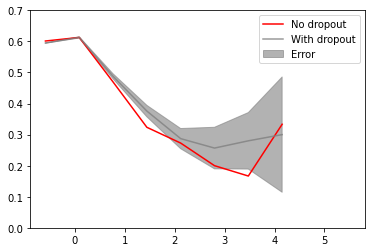

In [12]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(bins[:-1], Hbtag_jetPt/Hpretag_jetPt,'-',color="red", label="No dropout")
plt.plot(bins[:-1], btagg_efficiency,'-',color="gray", alpha=0.8, label="With dropout")
plt.fill_between(bins[:-1], btagg_efficiency- eff_errors,
                 btagg_efficiency+eff_errors, color="gray", alpha=0.6, label="")
plt.ylim(0,0.7)
plt.legend(loc="upper right")

### error VS pT

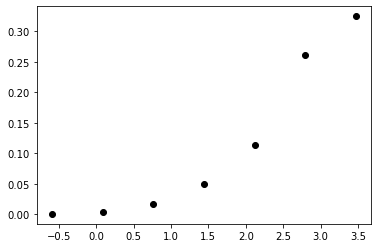

In [6]:
plt.plot(bins[:7], eff_errors[:7]/btagg_efficiency[:7], 'o', color='black')

In [7]:
btagg_efficiency

array([0.59480107, 0.61292977, 0.48774695, 0.37576471, 0.28704545,
       0.25666667, 0.28      , 0.3       ,        nan, 0.        ])

In [8]:
eff_errors

array([0.0003614 , 0.00206711, 0.00815503, 0.01853231, 0.0325651 ,
       0.0669162 , 0.09092121, 0.18559215,        nan, 0.        ])

In [ ]:
eff_errors/btagg_efficiency